In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import pickle
import torch
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from matchers import constant, dataset, metrics, utils
from matchers.models.autoencoder import AutoEncoder
from matchers.models import triplet_loss

In [4]:
MAX_NAME_LENGTH=30
char_to_idx_map, idx_to_char_map = utils.build_token_idx_maps()

### Load model

In [70]:
model = torch.load('../data/ae-bilstm-100.pth')

In [68]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load Ancestry data for fine-tuning and evaluation

In [7]:
train, test = dataset.load_process_from_disk()

input_names_train, weighted_relevant_names_train, candidates_train = train
input_names_test, weighted_relevant_names_test, candidates_test = test

relevant_names_train = [[name for name, _, _ in name_weights] for name_weights in weighted_relevant_names_train]
relevant_names_test = [[name for name, _, _ in name_weights] for name_weights in weighted_relevant_names_test]

all_candidates = np.concatenate((candidates_train, candidates_test))

### Train with WeRelate data

In [7]:
wr_df = pd.read_csv('../data/werelate_pairs.csv', dtype={'name1': object, 'name2': object})
# pandas reads nan as NaN; convert back to string nan
wr_df.fillna('nan', inplace=True)
wr_df

,Unnamed: 0,name1,name2,co_occurrence,count1,count2
0,0,ae,iye,0,0,0
1,1,ae,ase,0,0,0
2,2,ae,yah,0,0,0
3,3,ae,yeo,0,0,0
4,4,ae,aye,0,0,0
...,...,...,...,...,...,...
2644543,2644543,swarte,zwarts,0,0,0
2644544,2644544,zwetzig,zweizig,0,0,0
2644545,2644545,zweygardt,zwigard,0,0,0
2644546,2644546,zwickey,zwicki,0,0,0


In [8]:
input_names_wr, weighted_relevant_names_wr, all_candidates_wr = dataset.process(wr_df.copy())

In [9]:
print(len(input_names_wr), len(weighted_relevant_names_wr), all_candidates_wr.shape)
print(input_names_wr[0], weighted_relevant_names_wr[0], all_candidates_wr[0])

147255 147255 (154601,)
<aa> [('<ahi>', nan, 0), ('<ao>', nan, 0), ('<aye>', nan, 0), ('<azo>', nan, 0), ('<oe>', nan, 0), ('<oj>', nan, 0), ('<yah>', nan, 0), ('<yarrow>', nan, 0), ('<yate>', nan, 0), ('<yeo>', nan, 0)] <ahi>


In [ ]:
near_negatives_wr = triplet_loss.get_near_negatives(input_names_wr, weighted_relevant_names_wr, all_candidates_wr, k=50)

In [27]:
print(len(near_negatives_wr))

147255


In [33]:
# save near_negatives
with open('../data/werelate_near_negatives.pickle', 'wb') as f:
    pickle.dump(near_negatives_wr, f)

In [10]:
# load near_negatives
with open('../data/werelate_near_negatives.pickle', 'rb') as f:
    near_negatives_wr = pickle.load(f)

In [ ]:
triplet_loss.train_triplet_loss(model, input_names_wr, weighted_relevant_names_wr, near_negatives_wr, 
                                input_names_test, weighted_relevant_names_test, candidates_test, candidates_train, all_candidates,
                                char_to_idx_map, MAX_NAME_LENGTH, 20, 512, 0.1, 100, device)

  0%|          | 0/20 [00:00<?, ?it/s]

In [16]:
torch.save(model, '../data/ae-bilstm-100-werelate.pth')

In [43]:
model = torch.load('../data/ae-bilstm-100-werelate.pth')

### Fine-tune with Ancestry data

In [91]:
near_negatives = triplet_loss.get_near_negatives(input_names_train, weighted_relevant_names_train, candidates_train, k=50)

100%|██████████| 21374/21374 [12:10<00:00, 29.27it/s]


In [92]:
# save near_negatives
with open('../data/ancestry_near_negatives.pickle', 'wb') as f:
    pickle.dump(near_negatives, f)

In [8]:
# load near_negatives
with open('../data/ancestry_near_negatives.pickle', 'rb') as f:
    near_negatives = pickle.load(f)

In [71]:
triplet_loss.train_triplet_loss(model, input_names_train, weighted_relevant_names_train, near_negatives,
                                input_names_test, weighted_relevant_names_test, candidates_test, candidates_train, all_candidates,
                                char_to_idx_map, MAX_NAME_LENGTH, 20, 512, 0.05, 100, device)

  5%|▌         | 1/20 [00:49<15:46, 49.79s/it, loss=0.0103, auc=0.653]

test AUC 0.6526886635110692


 10%|█         | 2/20 [01:40<15:03, 50.18s/it, loss=0.00735, auc=0.663]

test AUC 0.6628777171401595


 15%|█▌        | 3/20 [02:31<14:23, 50.81s/it, loss=0.00774, auc=0.665]

test AUC 0.6648183126268367


 20%|██        | 4/20 [03:25<13:52, 52.04s/it, loss=0.00592, auc=0.662]

test AUC 0.6619407432529654


 25%|██▌       | 5/20 [04:19<13:12, 52.83s/it, loss=0.00437, auc=0.657]

test AUC 0.6565549463350492


 30%|███       | 6/20 [05:13<12:24, 53.15s/it, loss=0.00379, auc=0.658]

test AUC 0.6583782392872013


 35%|███▌      | 7/20 [06:07<11:34, 53.45s/it, loss=0.00364, auc=0.659]

test AUC 0.6589110466554532


 40%|████      | 8/20 [07:01<10:42, 53.56s/it, loss=0.00347, auc=0.673]

test AUC 0.6733615596586882


 45%|████▌     | 9/20 [07:55<09:49, 53.59s/it, loss=0.00312, auc=0.676]

test AUC 0.6757528235054063


 50%|█████     | 10/20 [08:49<08:58, 53.85s/it, loss=0.00295, auc=0.705]

test AUC 0.7046427082202035


 55%|█████▌    | 11/20 [09:43<08:04, 53.81s/it, loss=0.00282, auc=0.732]

test AUC 0.7323347982025575


 60%|██████    | 12/20 [10:36<07:09, 53.70s/it, loss=0.0029, auc=0.718] 

test AUC 0.7179593120241365


 65%|██████▌   | 13/20 [11:30<06:15, 53.69s/it, loss=0.00274, auc=0.715]

test AUC 0.7150159743217241


 70%|███████   | 14/20 [12:24<05:22, 53.71s/it, loss=0.00247, auc=0.797]

test AUC 0.7974314314989975


 75%|███████▌  | 15/20 [13:19<04:30, 54.10s/it, loss=0.00248, auc=0.737]

test AUC 0.7366275035158771


 80%|████████  | 16/20 [14:13<03:36, 54.18s/it, loss=0.00252, auc=0.72] 

test AUC 0.720325104381725


 85%|████████▌ | 17/20 [15:09<02:43, 54.54s/it, loss=0.00236, auc=0.855]

test AUC 0.8552214274125962


 90%|█████████ | 18/20 [16:03<01:49, 54.57s/it, loss=0.00219, auc=0.759]

test AUC 0.7590505721922669


 95%|█████████▌| 19/20 [16:57<00:54, 54.30s/it, loss=0.00221, auc=0.8]  

test AUC 0.8004591036074572


100%|██████████| 20/20 [17:50<00:00, 53.54s/it, loss=0.00213, auc=0.799]

test AUC 0.7989657988939928


In [72]:
torch.save(model, '../data/ae-bilstm-100-ancestry-20-05.pth')

In [48]:
model = torch.load('../data/ae-bilstm-100-ancestry-20.pth')

## Evaluation

In [73]:
# move to cpu for evaluation so we don't run out of GPU memory
model.to("cpu")
model.device="cpu"

In [74]:
# Get embeddings for train candidate names
X_train_inputs, _ = utils.convert_names_model_inputs(candidates_train,
                                                     char_to_idx_map, 
                                                     MAX_NAME_LENGTH)
# Get Embeddings for the names from the encoder
X_train_candidates_encoded = model(X_train_inputs, just_encoder=True).detach().numpy()

In [75]:
# Get embeddings for test input names
X_test_inputs, _ = utils.convert_names_model_inputs(input_names_test,
                                                    char_to_idx_map, 
                                                    MAX_NAME_LENGTH)
# Get Embeddings for the names from the encoder
X_input_names_encoded = model(X_test_inputs, just_encoder=True).detach().numpy()

In [76]:
# Get embeddings for test candidate names
X_test_candidate_inputs, _ = utils.convert_names_model_inputs(candidates_test, 
                                                              char_to_idx_map, 
                                                              MAX_NAME_LENGTH)
X_test_candidates_encoded = model(X_test_candidate_inputs, just_encoder=True).detach().numpy()

In [77]:
X_candidates_encoded = np.vstack((X_train_candidates_encoded, X_test_candidates_encoded))

In [78]:
k = 100
candidates = utils.get_candidates_batch(X_input_names_encoded, 
                                        X_candidates_encoded, 
                                        all_candidates,
                                        num_candidates=k)
print(candidates.shape)
print(candidates[0,0,0])
print(candidates[0,0,1])

(2444, 100, 2)
<abadusky>
0.9990407439927893


In [79]:
candidate_names = candidates[:, :, 0]
print(candidate_names.shape)

(2444, 100)


### PR Curve at k

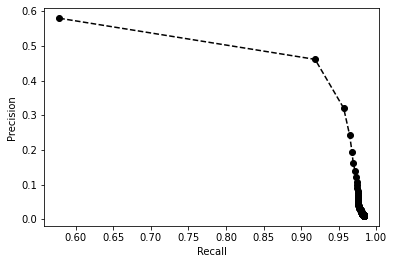

In [80]:
metrics.precision_recall_curve(relevant_names_test, candidate_names, k)

In [124]:
metrics.avg_precision_at_threshold(weighted_relevant_names_test, candidates, 0.9986)

0.6704566709885857

In [123]:
metrics.avg_recall_at_threshold(weighted_relevant_names_test, candidates, 0.9986)

0.8856602476151306

### PR Curve at threshold

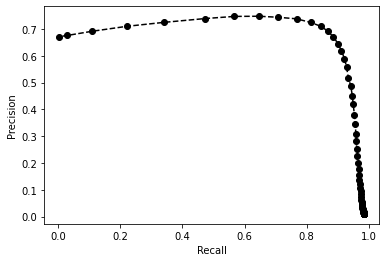

In [105]:
# minimum score threshold to test
metrics.precision_recall_curve_at_threshold(weighted_relevant_names_test, candidates, step=.0001)

### AUC

In [94]:
metrics.get_auc(weighted_relevant_names_test, candidates, step=.001)

0.7989657988939928